<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Arbitrary_Style_Transfer_in_Real_time_with_Adaptive_Instance_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization**

논문 링크: https://arxiv.org/abs/1703.06868

기존 style transfer의 원초적인 논문이라고 할 수 있는 **Image Style Transfer Using Convolutional Neural Networks**와 유사한 논문들의 경우는 **속도가 매우 느리며** 이를 극복하기 위해 나온 feed-forward 방식의 **Perceptual Losses for Real-Time Style Transfer and Super-Resolution** 등과 같은 논문의 경우는 미리 학습해놓은 **한정적인 style**에 대해서만 style transfer가 가능하였다.

## **AdaIN**

### **Architecture**

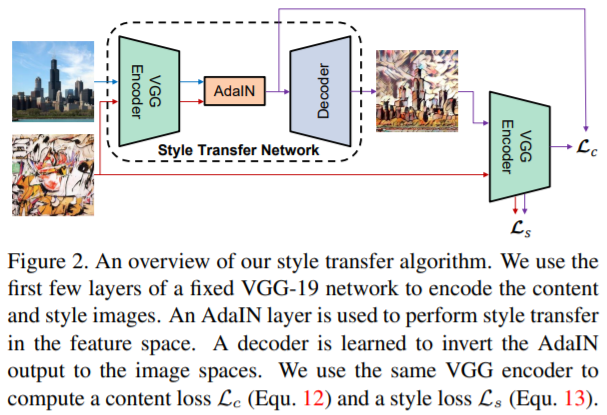

위의 그림 Figure 2를 보면 AdaIN network의 구조를 알 수 있다. 독특한 점은 pretrained VGG-19를 encoder로 사용하고 또한 이 encoder를 feature를 encoding할때와 loss function을 구할 때도 사용한다는 것이다. 이는 즉, **encoder는 학습을 시키지 않는다**라는 의미이다.

따라서 network에서 train을 진행시키는 것은 decoder뿐이며, 이 decoder는 AdaIN으로 생성된 feature들이 decoder를 통하여 image space로 invert하는 것을 train하게 된다.

### **AdaIN Layer**

그러면 위에서 언급한 Adaptive Instance Normalization(AdaIN)은 대체 무엇일까?

먼저 AdaIN을 살펴보기 전에 기존의 normalization 기법들을 살펴보겠다.

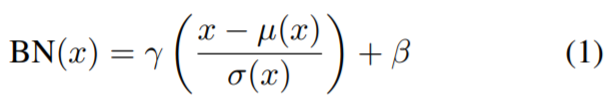

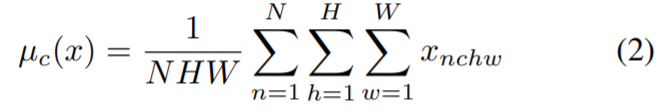

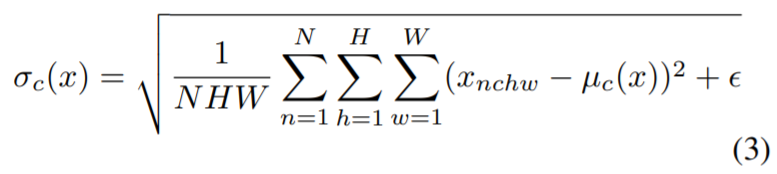

위의 식들은 기존의 feed-forward stylization method에서 사용된 batch normalization에 관한 식들이다. (자세한 설명은 생략하겠다.)

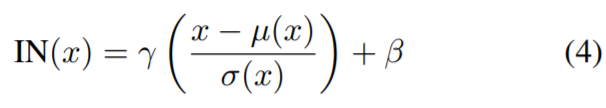

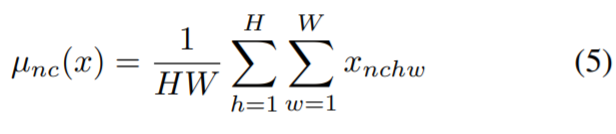

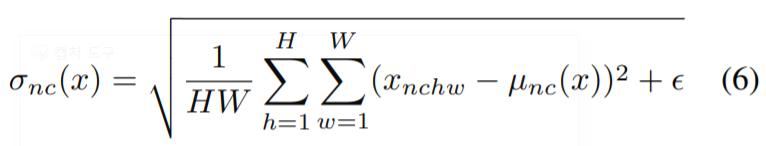

위의 식들은 instance normalization에 관한 식들인데, feed-forward 방식에서 단순히 BN을 IN으로 바꾸기만 했는데 성능을 높게 향상시켰다. 위의 식들을 보면 알 수 있겠지만 γ,β는 BN에서와 마찬가지로 학습되어야 하는 parameter이다.

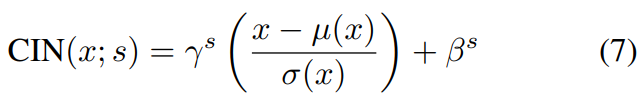

위의 식은 앞서 보았던 BN과 IN과 달리 생소할 수 있는 conditional instance normalization이다. CIN은 affine parameter인 γ, β를 하나만 train시키는 것이 아닌 각각의 style s에 대하여 γ^s, β^s를 train시키는 것이다.

train 진행시 style image를 각각 index s로 묶어 random하게 선택하여 style s에 대해 parameter를 학습한다. 이때 content image의 경우 CIN layer 상에서 γ^s와 β^s를 사용하는 style transfer network에 의해 처리된다.

이로인한 결과는 놀랍게도 network는 같은 parameter를 사용하며 다른 affine parameters를 IN layer에서 사용함으로써 완벽하게 다른 style를 생성할 수 있었다.

하지만, **style 갯수가 증가하면 parameter 갯수 또한 선형적으로 증가하며, 독립적인 새로운 style에 대해서는 train없이 적용할 수 없다**.

마지막으로 AdaIN을 살펴보기전 AdaIN의 아이디어를 이해하기 위한 왜 IN이 style transfer에 잘 작동하는지에 대한 의문을 본 논문에선 어떻게 해석했는지 알아보겠다.

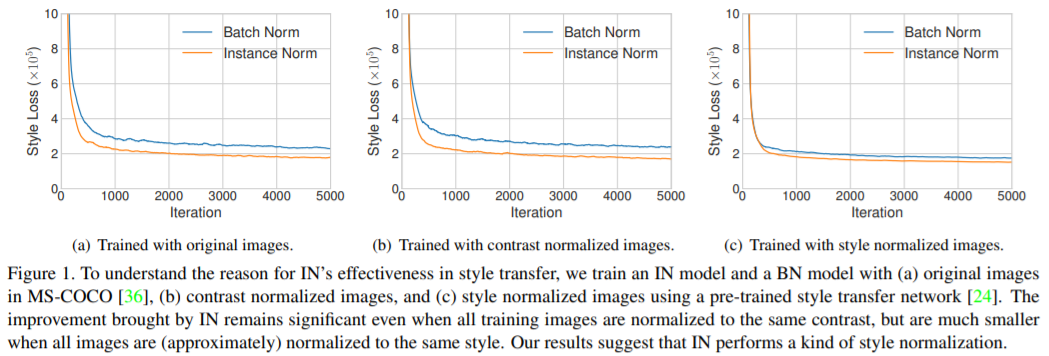

위의 그림 Figure 1을 보면 BN보다 확실히 IN에 의한 개선이 contrast에 대해 정규화한 image에 대해 차이난다. 하지만 style을 normalization한 실험에 대해서는 IN과 BN의 차이가 크지 않았는데, 따라서 본 논문에서는 IN이 일종의 style normalization이라고 주장한다.

BN은 single image의 feature statistics가 아니라 sample batch의 feature statistics를 정규화하기 때문에 직관적으로 batch상의 서로 다른 style들을 하나의 style 근처로 정규화한 것으로 이해할 수 있다. 따라서 성능이 하락될 수 있는 것이다. (이와 비슷한 맥락으로 style transfer에 대한 CIN 또한 이해할 수 있다.)

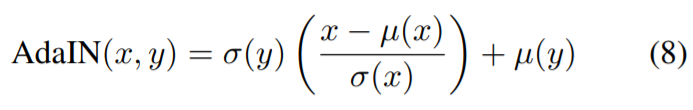

자 이제 본격적으로 AdaIN에 대하여 살펴보겠다. 전에 봤던 식들을 이해했으면 위의 식을 쉽게 이해할 수 있다.

먼저 위 식에서 σ와 μ는 각각 표준 편차와 평균을 구하는 함수다. 식을 해석해보자면, **(x - μ(x) / σ(x))는 contents image에서 content style을 빼준 것이고, 전체 식인 σ(y)(x - μ(x) / σ(x)) + μ(y)는 내가 입히고 싶은 image y의 style을 입혀준 것**이다.

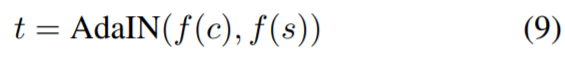

AdaIN layer를 통하여 생성되는 feature t는 위의 식과 같다. 이때 f는 pretrained VGG-19 (즉, encoder)이다.

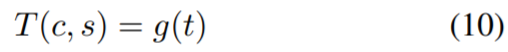

랜덤하게 초기화 된 decoder g는 t를 image space로 보내는 방법을 train하게 되며 style이 입혀진 image T(c,s)를 생성한다.

In [ ]:
def AdaIN(content, style):
    assert(content.size()[:2] == style.size()[:2])
    size = content.size()
    style_mean, style_std = calc_mean_std(style)
    content_mean, content_std = calc_mean_std(content)

    normalized = (content - content_mean.expand(size)) / content_std.expand(size)

    return normalized * style_std.expand(size) + style_mean.expand(size)

위의 코드를 보면 더 쉽게 이해할 수 있다.

### **Loss function**

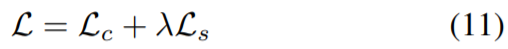

loss의 경우 의의 식과 같다.

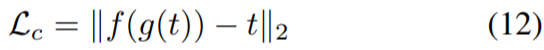

content loss(L_c)는 target feature와 output image의 feature의 Euclidean distance를 구한다. 일반적을 사용이 되는 content image의 feature response를 사용하는 대신 AdaIN output t를 content target으로 삼는다. 이렇게 하는 이유는 이 방법이 좀 더 빨리 convergence가 이루어지기 때문이다.

그냥 간단하게 위의 식을 설명하면 그냥 t를 decoder에 넣고 다시 encoder에 넣은 후 그 두개의 차이를 비교하는 것을 content loss로 한다는 것이다.

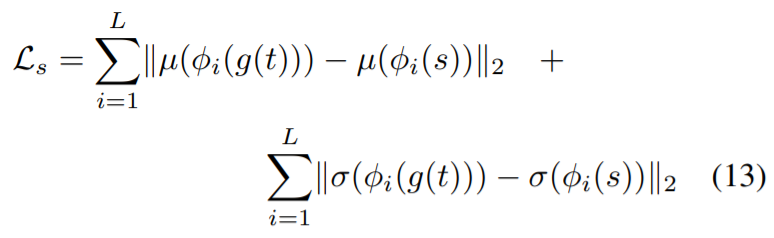

style loss(L_s)의 경우 AdaIN layer는 오직 style features의 mean과 standard deviation을 transfer하는 것이기 때문에 style loss는 이러한 statistics를 match해야한다. 따라서 위의 식과 같은 style loss를 사용하는 것이다.

위의 식 또한 간단하게 설명을 하자면, 원래 style s를 encoder에 넣었을 때의 i번째 feature ϕ_i(s)의 평균과 t를 encoder에 넣고 이를 다시 encoder에 넣었을 때의 i번째 feature ϕ_i(g(t))의 평균과 표준 편차를 최소화 시키는 것이다. 
(위의 식에서 ϕ_i는 VGG-19의 i 번째 layer이다. style loss에서 사용하는 layer는 relu1_1, relu2_1, relu3_1, relu4_1이다.)

## **Experiments**

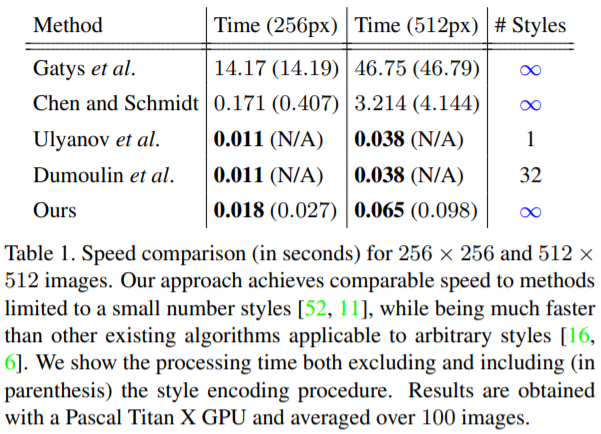

위의 표 Table 1을 보면 본 논문의 초반에서 큰 성과라고 언급하였던 속도와 style의 다양성을 확인할 수 있다.

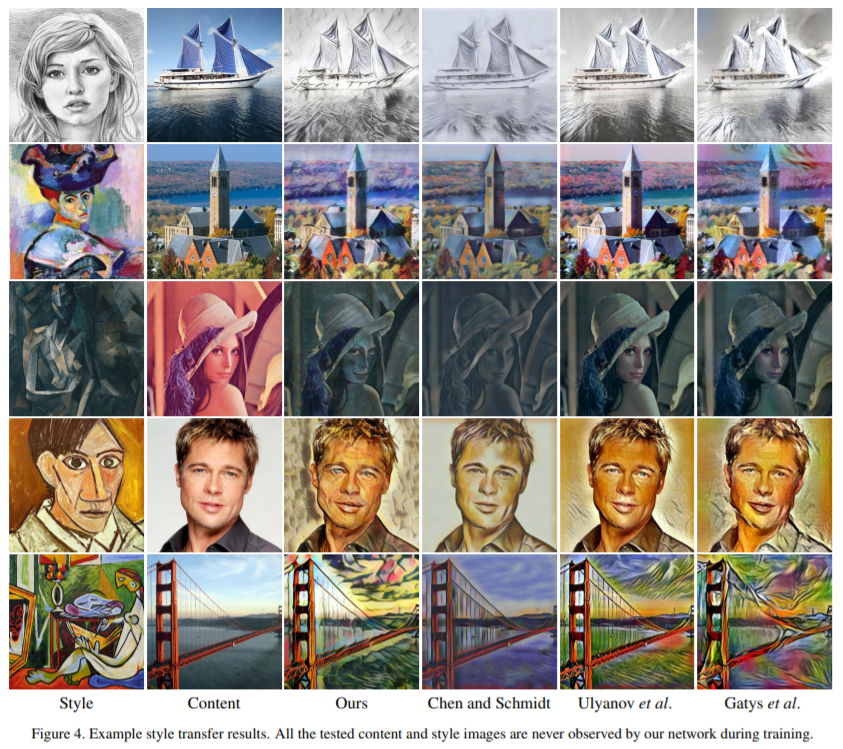

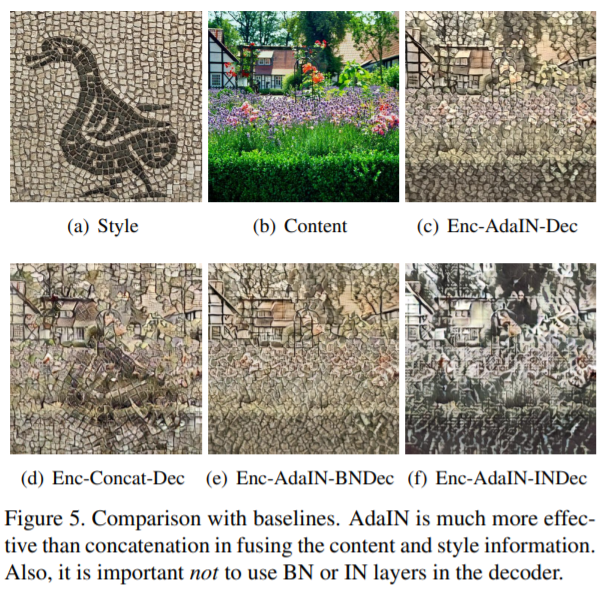

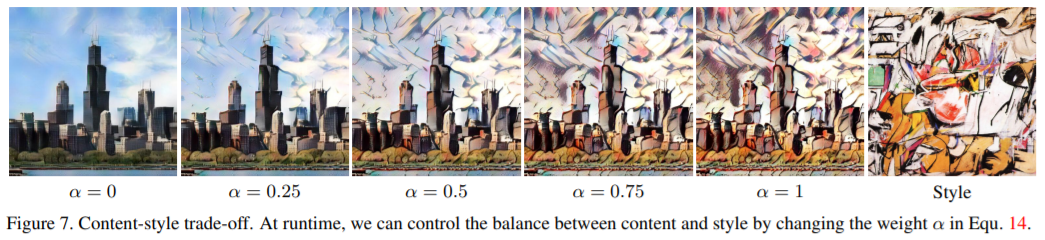

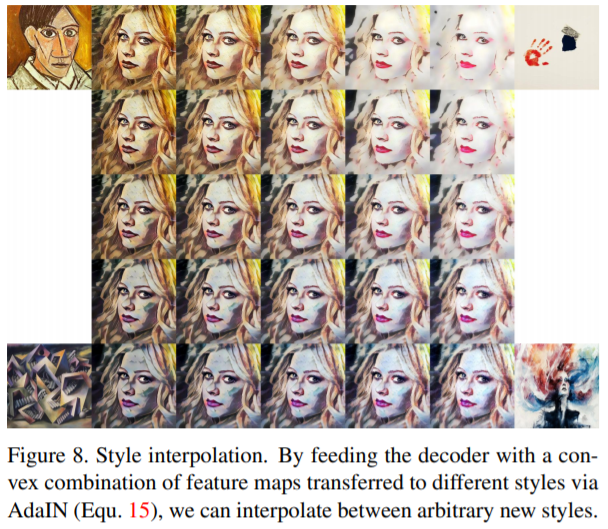

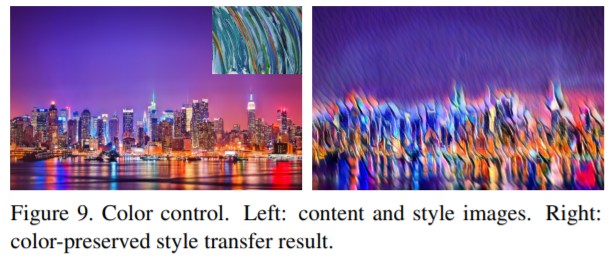

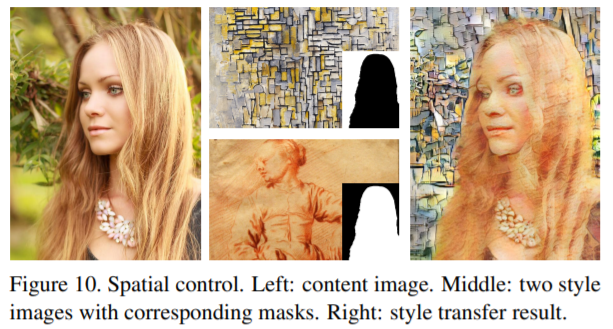

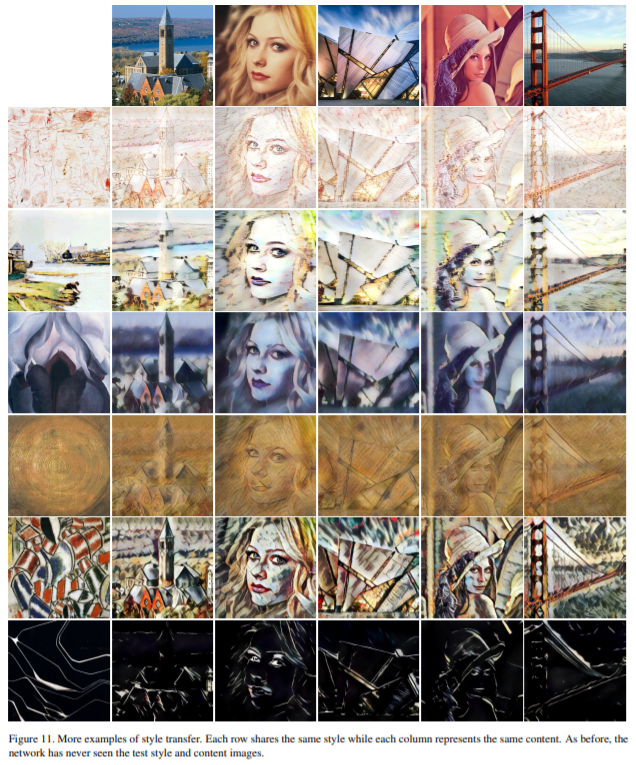

위의 그림 Figure 4에서 Figure 11을 보면 단순 속도나 다양성 뿐만아니라 결과물 역시 매우 뛰어난 것을 확인할 수 있다.